In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import copy

from collections import deque
import numpy as np
import argparse
import cv2
import imutils
import time
import matplotlib.pyplot as plt



In [ ]:
greenLower=(73,45,60)
greenUpper=(101,232,145)


yellowLower=(19,129,48)
yellowUpper=(75,202,214)

whiteLower=(15,16,80)
whiteUpper=(42,101,249)

redLower=(4,68,147)
redUpper=(10,211,255)

In [ ]:
white_ball={'Lower':(15,16,80),
            'Upper':(42,101,249),
           'Quadrant':-1}

green_ball={'Lower':(73,22,60),
            'Upper':(93,174,101),
           'Quadrant':-1}

yellow_ball={'Lower':(19,129,48),
            'Upper':(75,202,214),
           'Quadrant':-1}

red_ball={'Lower':(4,68,147),
            'Upper':(10,211,255),
           'Quadrant':-1}


In [ ]:
image_path='/content/drive/MyDrive/kaggle_datasets/opencv_object_detection_with_yolo/Mask_selector.jpg' 
vid_path='/content/drive/MyDrive/kaggle_datasets/opencv_object_detection_with_yolo/AI_Assignment_video.mp4'

In [ ]:
vs = cv2.VideoCapture(vid_path)

# checking the various metadata related to the frames shuch as FPS, frame width and frame height.
if (vs.isOpened() == False):
    print("Error opening the video file")
else:
    # Get frame rate information

    fps = int(vs.get(5))
    print("Frame Rate : ",fps,"frames per second")  

    # Get frame count
    frame_count = vs.get(7)
    print("Frame count : ", frame_count)

    frame_width= vs.get(3)
    print("Frame width: ", frame_width)

    frame_height= vs.get(4)
    print("frame height: ", frame_height)
    
mf= frame_width/400

Frame Rate :  30 frames per second
Frame count :  3183.0
Frame width:  1920.0
frame height:  1080.0


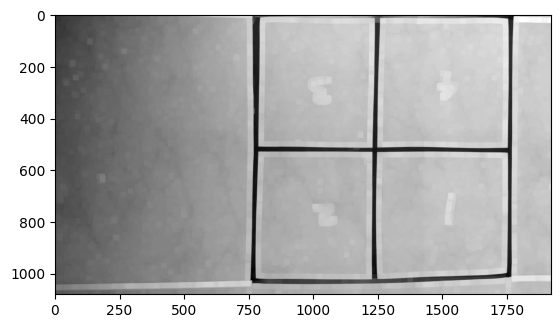

In [ ]:
img = vs.read()[1]
# img = cv2.flip(img,0)
# img = cv2.flip(img,1)


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
gray= ndimage.maximum_filter(gray,20) # Maximim filter used to supress artifacts giving false corners.

plt.imshow(gray, cmap='gray') #Gray scale image to be used for corner detection


1773 1046
743 3


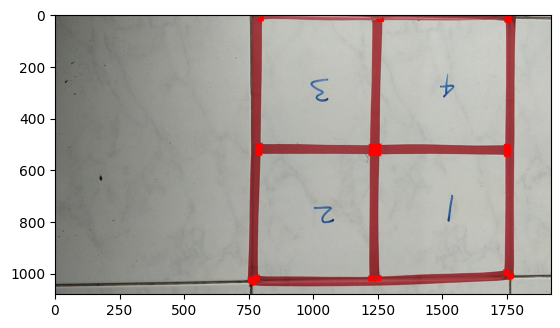

In [ ]:
corners = cv2.cornerHarris(gray, 30, 5, 0.05) # Harris corner detection algo

coordinates=np.argwhere(corners > 0.05 * corners.max())

x_max= coordinates.max(axis=0)[1]
x_min=coordinates.min(axis=0)[1]

y_max= coordinates.max(axis=0)[0]
y_min= coordinates.min(axis=0)[0]

tmp_img= copy.deepcopy(img)
tmp_img[corners> 0.05*corners.max()]=[0,0,255]
plt.imshow(tmp_img[:,:,::-1])

print(x_max, y_max)
print(x_min, y_min)

In [ ]:
x_mean= int((x_max+x_min)/2)
y_mean= int((y_max+y_min)/2)

print(x_mean, y_mean)

1258 524


In [ ]:
def gen_quadrant(x,y):
    if x < x_min or x>x_max or y<y_min or y>y_max:
        qdr=-1
        
    elif x<x_mean and y< y_mean:
        qdr= 3
    
    elif x> x_mean and y<y_mean:
        qdr=4
        
    elif x< x_mean and y> y_mean:
        qdr=2
        
    elif x>x_mean and y>y_mean:
        qdr=1
    else:
        qdr=-1
        
    return qdr

# Function to check is the quadrant of the ball has changed
def check_change_qdr(old_qdr, new_qdr):
    return old_qdr!=new_qdr

#Function to update the quadrant of the ball
def update_qdr(new_qdr, color):
    if color=='w':
        white_ball['Quadrant']=new_qdr
    
    elif color=='y':
        yellow_ball["Quadrant"]=new_qdr
        
    elif color=='r':
        red_ball['Quadrant']=new_qdr
        
    elif color=='g':
        green_ball['Quadrant']=new_qdr

#Function to get the present Quadrant of the ball        
def fetch_quadrant(color):
    if color=='w':
        qdr= white_ball['Quadrant']
    
    elif color=='y':
        qdr= yellow_ball["Quadrant"]
        
    elif color=='r':
        qdr=red_ball['Quadrant']
        
    elif color=='g':
        qdr=green_ball['Quadrant']
        
    return qdr


Messages=[] # List to keep the logs of the Events

#Function to generate suitable Log based on the event of change in quadrant
def get_message(new_qdr, old_qdr, color, time_stamp):

    time_stamp=round(time_stamp,2)
    if old_qdr==-1:
        message1="{}, {}, {}, Enter".format(time_stamp,new_qdr,color)
        Messages.append(message1)

        return message1
        
    elif new_qdr==-1:
        message1="{}, {}, {}, Exit". format(time_stamp,old_qdr, color)
        Messages.append(message1)
        return message1

    else:
        message1="{}, {}, {},Exit".format(time_stamp,old_qdr,color)
        message2="{}, {}, {},Enter".format(time_stamp,new_qdr,color)
        Messages.append(message1)
        Messages.append(message2)
        return message1 + " "+ message2

In [ ]:
def GetColor(image,x,y):
    h,s,v= image[y,x,:]
    if (greenLower[0]<=h<=greenUpper[0]) and (greenLower[1]<=s<=greenUpper[1]) and (greenLower[2]<=v<=greenUpper[2]):
        return('g')
    elif (yellowLower[0]<=h<=yellowUpper[0]) and (yellowLower[1]<=s<=yellowUpper[1]) and (yellowLower[2]<=v<=yellowUpper[2]):
        return('y')
    elif (whiteLower[0]<=h<=whiteUpper[0]) and (whiteLower[1]<=s<=whiteUpper[1]) and (whiteLower[2]<=v<=whiteUpper[2]):
        return('w')
    elif (redLower[0]<=h<=redUpper[0]) and (redLower[1]<=s<=redUpper[1]) and (redLower[2]<=v<=redUpper[2]):
        return('r')

In [ ]:
def white_detector(img, time_stamp=0):
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 0.8, 100, param2=55, minRadius=30)
    white_flag=-1
    if circles is not None:
        for (x, y, r) in circles[0]:
            if r>=30 and r<=70:
                x=int(round(x))
                y=int(round(y))
                r=int(round(r))
                color=GetColor(img_hsv,x,y)
                if color=='w':
                    white_flag=1
                    cv2.circle(img, (x, y), r, (0, 255, 0), 4)
                    cv2.putText(img,color,(int(x+1.2*r),
                                             int(y+1.2*r)),cv2.FONT_HERSHEY_SIMPLEX,3,(0, 255, 0),2,cv2.LINE_AA)
                    
                    new_qdr=gen_quadrant(x,y)
                    old_qdr=fetch_quadrant(color)
                    if check_change_qdr(old_qdr, new_qdr):
                        message=get_message(new_qdr, old_qdr, color,time_stamp)
                        print(message)
                        update_qdr(new_qdr, color)
                        
    if white_flag==-1:
        color='w'
        old_qdr=fetch_quadrant(color)
        new_qdr=-1
        if check_change_qdr(old_qdr, new_qdr):
            message=get_message(new_qdr, old_qdr, color,time_stamp)
            print(message)
            update_qdr(new_qdr, color)

In [ ]:
def yellow_red_green_detector(img, color, time_stamp=0):
    
    if color=='r':
        colorLower=redLower
        colorUpper=redUpper
    elif color=='y':
        colorLower=yellowLower
        colorUpper= yellowUpper
    elif color=='g':
        colorLower=greenLower
        colorUpper=greenUpper
    img_hsv=cv2.cvtColor(img, cv2.COLOR_BGR2HSV)    
    mask_color = cv2.inRange(img_hsv, colorLower, colorUpper)
    mask_color = cv2.erode(mask_color, None, iterations=5)
    mask_color = cv2.dilate(mask_color, None, iterations=10)
    mask_color=ndimage.minimum_filter(mask_color, size=10)
    cnts= cv2.findContours(mask_color.copy(), cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        if (len(c)>20):
            #print('length of cntr:',len(c))
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            x=int(x)
            y=int(y)
            radius=int(radius)
            center=(int(x), int(y))
            cv2.circle(img,center,radius,(0, 255, 0),4)
            cv2.putText(img,color,(int(x+1.2*radius),
                        int(y+1.2*radius)),cv2.FONT_HERSHEY_SIMPLEX,3,(0, 255, 0),2,cv2.LINE_AA)
            
            new_qdr=gen_quadrant(x,y)
            old_qdr=fetch_quadrant(color)
            if check_change_qdr(old_qdr, new_qdr):
                message=get_message(new_qdr, old_qdr, color,time_stamp)
                print(message)
                update_qdr(new_qdr, color)
                
    else:
        old_qdr=fetch_quadrant(color)
        new_qdr=-1
        if check_change_qdr(old_qdr, new_qdr):
            message=get_message(new_qdr, old_qdr, color,time_stamp)
            print(message)
            update_qdr(new_qdr, color)

In [ ]:
def main_process(image, time_stamp=0):
    
    white_detector(image)
    yellow_red_green_detector(image, 'y')
    yellow_red_green_detector(image, 'r')
    yellow_red_green_detector(image, 'g')
    
    

In [ ]:
mf= frame_width/800

frame_width = int(vs.get(3))
frame_height = int(vs.get(4))
   
size = (int(frame_width/mf), int(frame_height/mf))
result = cv2.VideoWriter('Track.mp4', 
                         cv2.VideoWriter_fourcc(*'XVID'),
                         vs.get(5), size)
i=0
while True:

    frame = vs.read()
    frame = frame[1]
    # frame = cv2.flip(frame,0)
    # frame = cv2.flip(frame,1)
    if frame is None:
        break
    time_stamp=vs.get(cv2.CAP_PROP_POS_MSEC)
    main_process(frame)
    # plt.imshow(frame[:,:,::-1])
    frame=imutils.resize(frame,800)
#     result.write(frame)
    # cv2.imshow('frame', frame)  
    # k = cv2.waitKey(30) & 0xff
    # if k == 27:
    #     break
    result.write(frame)
vs.release()
result.release()
# cv2.destroyAllWindows()

0, 1, y, Enter
0, 1, y,Exit 0, 3, y,Enter
0, 2, w, Enter
0, 1, g, Enter
0, 1, g,Exit 0, 4, g,Enter
0, 2, w, Exit
0, 2, w, Enter
0, 2, w, Exit
0, 2, w, Enter
0, 2, w, Exit
0, 2, w, Enter
0, 1, r, Enter
0, 2, w, Exit
0, 2, w, Enter
0, 2, w, Exit
0, 4, g, Exit
0, 1, r, Exit
0, 4, w, Enter
0, 2, r, Enter
0, 2, r, Exit
0, 2, r, Enter
0, 3, y, Exit
0, 1, y, Enter
0, 1, y, Exit
0, 1, g, Enter
0, 1, g,Exit 0, 2, g,Enter
0, 2, g,Exit 0, 3, g,Enter
0, 1, y, Enter
0, 2, r, Exit
0, 1, y, Exit
0, 3, g,Exit 0, 2, g,Enter
0, 2, g,Exit 0, 1, g,Enter
0, 1, g, Exit
0, 1, y, Enter
0, 1, y,Exit 0, 2, y,Enter
0, 2, y,Exit 0, 3, y,Enter
0, 1, r, Enter
0, 1, g, Enter
0, 1, g,Exit 0, 4, g,Enter
0, 4, w, Exit
0, 4, g,Exit 0, 1, g,Enter
0, 1, g, Exit
0, 1, g, Enter
0, 1, g,Exit 0, 4, g,Enter
0, 2, w, Enter
0, 2, w, Exit
0, 2, w, Enter
0, 1, r, Exit
0, 4, g,Exit 0, 1, g,Enter
0, 1, g, Exit
0, 1, g, Enter
0, 1, g, Exit
0, 2, w, Exit
0, 3, y, Exit
0, 3, y, Enter
0, 3, y,Exit 0, 2, y,Enter
0, 2, y, Exit
0, 1, y, En

In [ ]:
with open('Log.txt', 'w') as f:
    for line in Messages:
        f.write(f"{line}\n")